In [2]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
def append_ext(fn):
    return fn+".png"

train_classes=pd.read_csv('/Users/gustavonrm/Desktop/VCOM/proj2/multiclass.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_classes['attribute_ids']=train_classes['attribute_ids'].str.split(' ')
train_classes["id"]=train_classes["id"].apply(append_ext)


print('train : \n', train_classes.head())

train : 
                      id attribute_ids
0  1000fe2e667721fe.png          [51]
1  10041eb49b297c08.png          [51]
2  100501c227f8beea.png          [13]
3  1008abd71f3ed5bc.png          [70]
4  100a0dcde728cb36.png          [51]


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="training",
                                             target_size = (64,64),
                                             batch_size=64,
                                             class_name='categorical')

valid_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="validation",
                                             target_size = (64,64),
                                             batch_size=64,
                                             class_name='categorical')

Found 17670 validated image filenames belonging to 50 classes.
Found 4417 validated image filenames belonging to 50 classes.


In [5]:
model = models.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5),padding='Same', input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(filters=32, kernel_size=(5,5),padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(2048))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(50, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0

In [6]:
from keras import optimizers

optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", "categorical_accuracy"])
# model.compile(optimizer=optimizer, loss="binary_crossentropy",metrics=["accuracy", "categorical_accuracy"])

STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    verbose=1)

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/10
276/276 [==============================] - 483s 2s/step - loss: 2.0846 - accuracy: 0.4494 - categorical_accuracy: 0.4494 - val_loss: 2.4002 - val_accuracy: 0.3614 - val_categorical_accuracy: 0.3614
Epoch 2/10
276/276 [==============================] - 467s 2s/step - loss: 1.6764 - accuracy: 0.5119 - categorical_accuracy: 0.5119 - val_loss: 1.6192 - val_accuracy: 0.5401 - val_categorical_accuracy: 0.5401
Epoch 3/10
276/276 [==============================] - 403s 1s/step - loss: 1.5282 - accuracy: 0.5388 - categorical_accuracy: 0.5388 - val_loss: 1.5531 - val_accuracy: 0.5272 - val_categorical_accuracy: 0.5272
Epoch 4/10
276/276 [==============================] - 387s 1s/step - loss: 1.4184 - accuracy: 0.5621 - categorical_accuracy: 0.5621 - val_loss: 1.4719 - val_accuracy: 0.5546 - val_cate

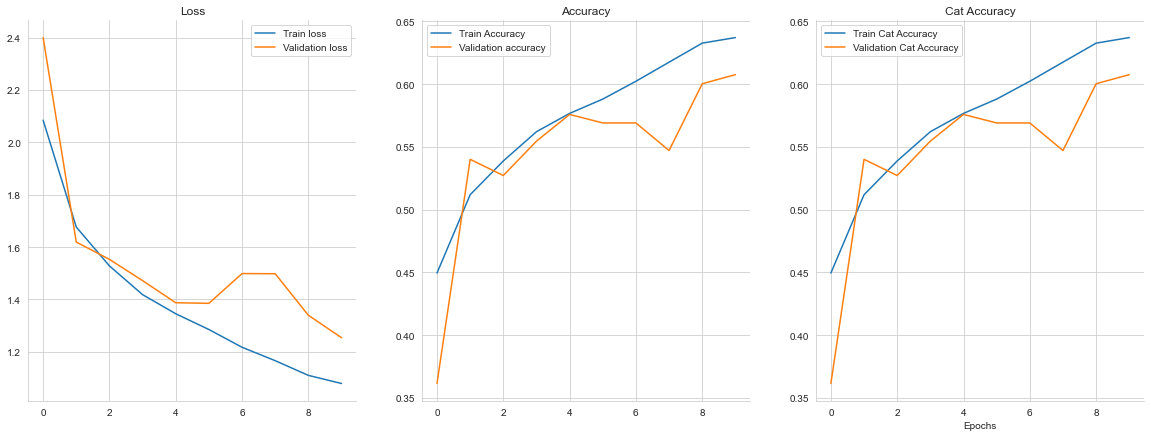

In [9]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()